___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://miro.medium.com/0*uENSggbf2NdgFf9b.png" width="350px" height="180px" />


# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
#### <font color= #2E9AFE> `Martes y Viernes (Videoconferencia) de 13:00 - 15:00 hrs`</font>
- <Strong> Sara Eugenia Rodríguez </Strong>
- <Strong> Año </Strong>: 2025
- <Strong> Email: </Strong>  <font color="blue"> `sara.rodriguezr@iteso.mx` </font>
___

<p style="text-align:right;"> Imagen recuperada de: https://miro.medium.com/0*uENSggbf2NdgFf9b.png</p>

### <font color= #2E9AFE> Tema: Calibración de probabilidades en clasificación</font>


En clasificación, los algoritmos optimizan funciones y métricas de costos de todo o nada.

Por ejemplo, la precisión sólo mide la frecuencia con la que acertamos y no dice nada sobre la confianza que tenemos en acertar, no mide "distancias" entre la realidad y la predición. 

En clasificación no tiene sentido decir que la distancia entre una foto de una avispa y una foto de una abeja es 5, al menos no de la misma manera que tiene sentido decir que la distancia entre el precio de un AirBnB de un dormitorio y el precio medio de otro AirBnB promedio de un dormitorio en el mismo vecindario es de $50.

Como resultado, los algoritmos de clasificación tienden a tener pronósticos de predicción de probabilidad mucho más débiles y más sistemáticamente sesgados. Para casos en los que solo importa la clase asignada y no nos importa la confianza que tengamos en que esa probabilidad sea correcta, esto está bien. Si nos preocupamos por las probabilidades (por ejemplo, estamos compitiendo en una competencia de Kaggle cuya métrica es la pérdida logarítmica), este es un problema importante.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

In [2]:
#Datos dummies
np.random.seed(42)
X, y = make_classification(n_samples=10000, n_features=20, 
                           n_informative=2, n_redundant=2, 
                           n_classes=2, flip_y=0.1,
                           random_state=42)


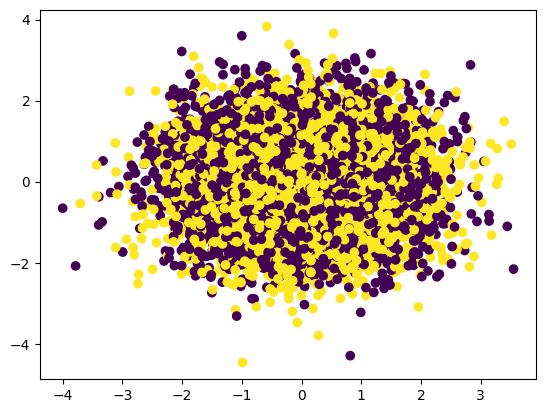

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
#Dividimos en entranmiento, validación(calibracion) y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Paso 1: Entrenamos modelo normalmente

In [5]:
#Regresion logistica
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

#Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

#SVC
model_svm = SVC(C=1.0, random_state=42, probability=True, kernel='linear')
model_svm.fit(X_train, y_train)

#Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Paso 2: Predecir probabilidades sin calibrar

In [6]:
#Regresion logistica
probs_lr_uncal = model_lr.predict_proba(X_test)[:, 1]

#Naive Bayes
probs_nb_uncal = model_nb.predict_proba(X_test)[:, 1]

#SVM
probs_svm_uncal = model_svm.predict_proba(X_test)[:, 1]

#RF
probs_rf_uncal = model_rf.predict_proba(X_test)[:, 1]

### Paso 3: Ajustar calibradores

Importante: usar cv="prefit" porque el modelo ya fue entrenado

In [7]:
#Regresion logistica
platt_lr = CalibratedClassifierCV(model_lr, method='sigmoid', cv='prefit')
platt_lr.fit(X_calib, y_calib)

iso_lr = CalibratedClassifierCV(model_lr, method='isotonic', cv='prefit')
iso_lr.fit(X_calib, y_calib)

#Naive Bayes
platt_nb = CalibratedClassifierCV(model_nb, method='sigmoid', cv='prefit')
platt_nb.fit(X_calib, y_calib)

iso_nb = CalibratedClassifierCV(model_nb, method='isotonic', cv='prefit')
iso_nb.fit(X_calib, y_calib)

#SVC
platt_svm = CalibratedClassifierCV(model_svm, method='sigmoid', cv='prefit')
platt_svm.fit(X_calib, y_calib)

iso_svm = CalibratedClassifierCV(model_svm, method='isotonic', cv='prefit')
iso_svm.fit(X_calib, y_calib)

#Random Forest
platt_rf = CalibratedClassifierCV(model_rf, method='sigmoid', cv='prefit')
platt_rf.fit(X_calib, y_calib)

iso_rf = CalibratedClassifierCV(model_rf, method='isotonic', cv='prefit')
iso_rf.fit(X_calib, y_calib)


/home/isaac/Documents/code/python/data_modeling/venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/isaac/Documents/code/python/data_modeling/venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/isaac/Documents/code/python/data_modeling/venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/isaac/Documents/code/python/data_modeling/venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='pr

,estimator,RandomForestClassifier()
,method,'isotonic'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


### Paso 4: Obtener probabilidades calibradas en el test

In [8]:
#Regresion logistica
probs_lr_platt = platt_lr.predict_proba(X_test)[:, 1]
probs_lr_iso = iso_lr.predict_proba(X_test)[:, 1]

#Naive Bayes
probs_nb_platt = platt_nb.predict_proba(X_test)[:, 1]
probs_nb_iso = iso_nb.predict_proba(X_test)[:, 1]

#SVC
probs_svm_platt = platt_svm.predict_proba(X_test)[:, 1]
probs_svm_iso = iso_svm.predict_proba(X_test)[:, 1]

#RF
probs_rf_platt = platt_rf.predict_proba(X_test)[:, 1]
probs_rf_iso = iso_rf.predict_proba(X_test)[:, 1]

### Paso 5: Evaluar con Brier Score

In [9]:
#Regresion logistica
print("------Regresion Logistica-----")
print("Brier sin calibrar:", brier_score_loss(y_test, probs_lr_uncal))
print("Brier Platt:", brier_score_loss(y_test, probs_lr_platt))
print("Brier Isotonic:", brier_score_loss(y_test, probs_lr_iso))

#Naive Bayes
print("------Naive Bayes-----")
print("Brier sin calibrar:", brier_score_loss(y_test, probs_nb_uncal))
print("Brier Platt:", brier_score_loss(y_test, probs_nb_platt))
print("Brier Isotonic:", brier_score_loss(y_test, probs_nb_iso))

#SVC
print("------SVC-----")
print("Brier sin calibrar:", brier_score_loss(y_test, probs_svm_uncal))
print("Brier Platt:", brier_score_loss(y_test, probs_svm_platt))
print("Brier Isotonic:", brier_score_loss(y_test, probs_svm_iso))

#RF
print("------Random Forest-----")
print("Brier sin calibrar:", brier_score_loss(y_test, probs_rf_uncal))
print("Brier Platt:", brier_score_loss(y_test, probs_rf_platt))
print("Brier Isotonic:", brier_score_loss(y_test, probs_rf_iso))

------Regresion Logistica-----
Brier sin calibrar: 0.11723520862496425
Brier Platt: 0.11726348711272283
Brier Isotonic: 0.11507042108164907
------Naive Bayes-----
Brier sin calibrar: 0.12747192929769247
Brier Platt: 0.12355177386942992
Brier Isotonic: 0.12231516592197322
------SVC-----
Brier sin calibrar: 0.11729827257472959
Brier Platt: 0.11713496442424784
Brier Isotonic: 0.11561806736155876
------Random Forest-----
Brier sin calibrar: 0.09077684999999999
Brier Platt: 0.0875723986796444
Brier Isotonic: 0.0874918609764189


### Paso 6: Curvas de calibracion

In [10]:
def plot_calibration_curves(model_name, y_test, uncal, platt, iso):
    
    fr_uncal, pr_uncal = calibration_curve(y_test, uncal, n_bins=10)
    fr_platt, pr_platt = calibration_curve(y_test, platt, n_bins=10)
    fr_iso, pr_iso     = calibration_curve(y_test, iso, n_bins=10)

    plt.figure(figsize=(6,5))
    plt.plot(pr_uncal, fr_uncal, marker="o", label="Sin calibrar")
    plt.plot(pr_platt, fr_platt, marker="o", label="Platt scaling (sigmoid)")
    plt.plot(pr_iso,   fr_iso,   marker="o", label="Isotonic regression")
    plt.plot([0, 1], [0, 1], "--", color="gray")

    plt.title(f"Curva Calibracion - {model_name}")
    plt.xlabel("Probabilidad predicha")
    plt.ylabel("Frecuencia Observada")
    plt.legend()
    plt.grid()
    plt.show()

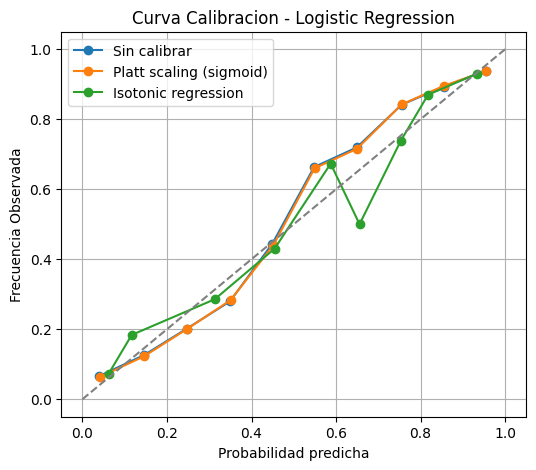

In [11]:
plot_calibration_curves("Logistic Regression", y_test, probs_lr_uncal, probs_lr_platt, probs_lr_iso)

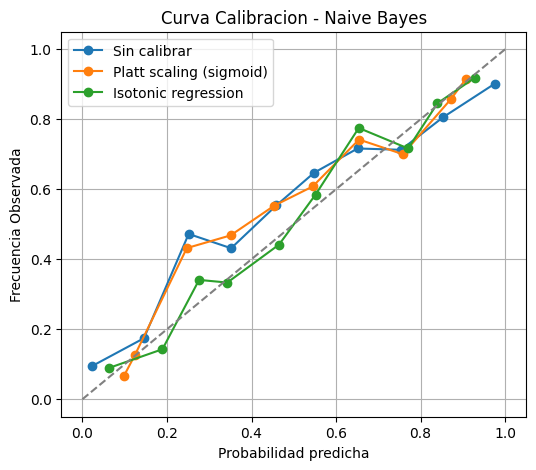

In [12]:
plot_calibration_curves("Naive Bayes", y_test, probs_nb_uncal, probs_nb_platt, probs_nb_iso)

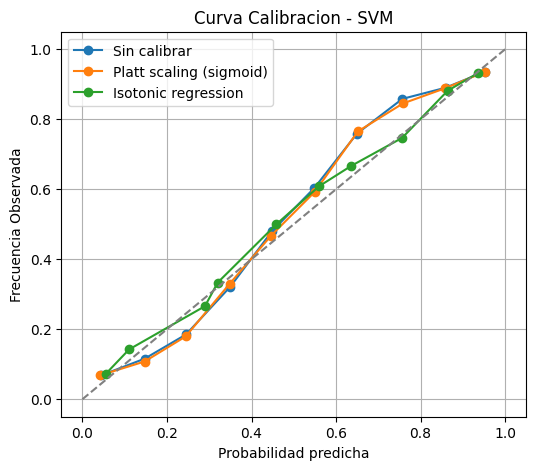

In [13]:
plot_calibration_curves("SVM", y_test, probs_svm_uncal, probs_svm_platt, probs_svm_iso)

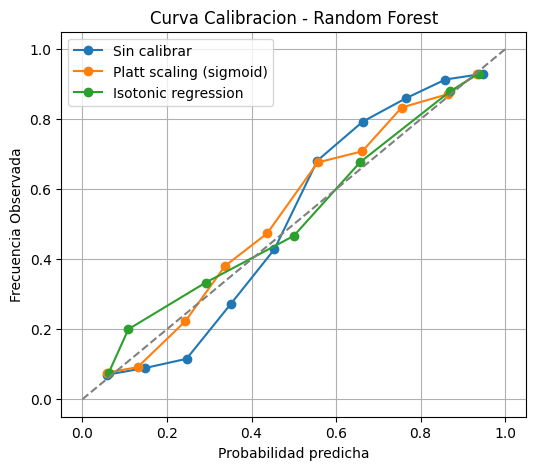

In [14]:
plot_calibration_curves("Random Forest", y_test, probs_rf_uncal, probs_rf_platt, probs_rf_iso)